In [1]:
import cv2
import csv
import os
import sys
import scipy
import numpy
import matplotlib
import pandas
import sklearn
import pickle
import numpy as np
import os
import pickle

In [2]:
# Load libraries
from pandas import read_csv
from pandas.plotting import scatter_matrix
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC


In [3]:
# Reference no.1 = https://blog.finxter.com/5-best-ways-to-remove-black-background-and-make-it-transparent-using-opencv-python/
# Reference no.2 = https://www.geeksforgeeks.org/image-thresholding-in-python-opencv/
# Reference no.3 = https://docs.opencv.org/3.4/d7/d4d/tutorial_py_thresholding.html
# Reference no.4 = https://herts.instructure.com/courses/112101/pages/running-python-simply?module_item_id=36661346
# Reference no.5 = https://machinelearningmastery.com/machine-learning-in-python-step-by-step/
# Reference no.6 = https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.concat.html
# Reference no.7 = https://www.geeksforgeeks.org/python-extracting-rows-using-pandas-iloc/
# Reference no.8 = https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.values.html
# Reference no.9 = https://stackoverflow.com/questions/37891954/keras-how-do-i-predict-after-i-trained-a-model

In [4]:

# The directory path where the healthy images are located
directory = "./images/NORMAL"

# Get all the image files in the directory
image_files = [f for f in os.listdir(directory) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.jfif'))]

# Process each image file
for image_file in image_files:
    # Construct full image path
    image_path = os.path.join(directory, image_file)

    # Read the image
    image = cv2.imread(image_path)

    if image is None:
        print(f"Could not read {image_file}, skipping.")
        continue

    # Convert the image to greyscale
    grey_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply CLAHE (Contrast-Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    equalised_image = clahe.apply(grey_image)

    # Apply Otsu's thresholding to enhance lung regions
    _, thresholded = cv2.threshold(equalised_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Find contours
    contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        # Use the largest external contour
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)

        # Crop the region of interest
        crop = equalised_image[y:y+h, x:x+w]

        # Resize the image to 224x224
        resized_crop = cv2.resize(crop, (224, 224))

        # Normalize pixel values to range [0,1]
        normalized_image = resized_crop / 255.0

        # Save grayscale pixel values to CSV
        csv_file_name = os.path.splitext(image_file)[0] + '.csv'
        csv_file_path = os.path.join(directory, csv_file_name)

        with open(csv_file_path, 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(["Greyscale"])
            for i in range(resized_crop.shape[0]):
                for j in range(resized_crop.shape[1]):
                    writer.writerow([resized_crop[i, j]])
    else:
        print(f"No contours found for {image_file}, skipping.")

print("All normal files processed.")

All normal files processed.


In [5]:
# Directory containing the CSV files
summary_file_path = os.path.join(directory, "normal summary means.csv")

# Initialise a list to store the summary data
summary_data = []

# Process each CSV file in the directory
for csv_file in os.listdir(directory):
    if csv_file.endswith('.csv'):
        csv_file_path = os.path.join(directory, csv_file)
        with open(csv_file_path, 'r', newline='') as file:
            reader = csv.reader(file)
            next(reader)  # Skip header

            # Initialise the sum and count variables
            grey_sum = 0
            count = 0

            # Sum greyscale values
            for row in reader:
                if row:  # Check if the row is not empty
                    grey_value = float(row[0])  # There's only one greyscale value per row
                    grey_sum += grey_value
                    count += 1

            # Calculate the mean greyscale value
            grey_mean = grey_sum / count if count else 0

            # Add the calculated mean to the summary list with the file name as "Building" column
            summary_data.append([grey_mean, "Normal", os.path.splitext(csv_file)[0]])

# Write the summary data to a new CSV file with the appropriate headers
with open(summary_file_path, 'w', newline='') as summary_file:
    writer = csv.writer(summary_file)
    writer.writerow(["Greyscale Mean", "Category", "File Name"])
    for data in summary_data:
        writer.writerow(data)

print("Summary of means for normal has been written.")

Summary of means for normal has been written.


In [6]:
# The directory path where the healthy images are located
directory = "./images/PNEUMONIA" 

# Get all the image files in the directory
image_files = [f for f in os.listdir(directory) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.jfif' ))]

# Process each image file
for image_file in image_files:
    # Read the image
    image_path = os.path.join(directory, image_file)
    image = cv2.imread(image_path)
    
    # Convert the image to greyscale
    grey_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply CLAHE (Contrast-Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))  # Set CLAHE parameters
    equalised_image = clahe.apply(grey_image)  # Apply CLAHE

    # Apply Otsu's thresholding to enhance lung regions
    _, thresholded = cv2.threshold(equalised_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Find contours
    contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if contours:  # Ensure at least one contour is found
        # Assume the largest external contour is the object to keep
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        
        # Crop the image using the dimensions of the bounding rectangle
        crop = equalised_image[y:y+h, x:x+w]
        
        # Resize image to 224x224 for deep learning models
        resized_crop = cv2.resize(crop, (224, 224))

        # Normalize pixel values to range [0,1]
        normalized_image = resized_crop / 255.0

        # Create new alpha channel with same dimensions as cropped image
        alpha_channel = numpy.ones(resized_crop.shape[:2], dtype='uint8') * 255
        
        # Add alpha channel to cropped image
        rgba = cv2.merge((*cv2.split(resized_crop), alpha_channel))

        # Create the CSV file name by removing the image extension and adding .csv
        csv_file_name = os.path.splitext(image_file)[0] + '.csv'
        csv_file_path = os.path.join(directory, csv_file_name)

        # Open the CSV file and write the headers and greyscale values
        with open(csv_file_path, 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(["Greyscale"])

            # Write the greyscale values for each pixel
            for i in range(resized_crop.shape[0]):
                for j in range(resized_crop.shape[1]):
                    grey_value = resized_crop[i, j]
                    writer.writerow([grey_value])

print("All pneumonia files processed.")

All pneumonia files processed.


In [7]:
# Directory containing the CSV files
summary_file_path = os.path.join(directory, "pneumonia summary means.csv")

# Initialise a list to store the summary data
summary_data = []

# Process each CSV file in the directory
for csv_file in os.listdir(directory):
    if csv_file.endswith('.csv'):
        csv_file_path = os.path.join(directory, csv_file)
        with open(csv_file_path, 'r', newline='') as file:
            reader = csv.reader(file)
            next(reader)  # Skip header

            # Initialise the sum and count variables
            grey_sum = 0
            count = 0

            # Sum greyscale values
            for row in reader:
                if row:  # Check if the row is not empty
                    grey_value = float(row[0])  # There's only one greyscale value per row
                    grey_sum += grey_value
                    count += 1

            # Calculate the mean greyscale value
            grey_mean = grey_sum / count if count else 0

            # Add the calculated mean to the summary list with the file name as "Building" column
            summary_data.append([grey_mean, "Pneumonia", os.path.splitext(csv_file)[0]])

# Write the summary data to a new CSV file with the appropriate headers
with open(summary_file_path, 'w', newline='') as summary_file:
    writer = csv.writer(summary_file)
    writer.writerow(["Greyscale Mean", "Category", "File Name"])
    for data in summary_data:
        writer.writerow(data)

print("Summary of means for pneumonia has been written.")

Summary of means for pneumonia has been written.


In [8]:
# The directory path where the healthy images are located
directory = "./images/TEST SET" 

# Get all the image files in the directory
image_files = [f for f in os.listdir(directory) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.jfif' ))]

# Process each image file
for image_file in image_files:
    # Read the image
    image_path = os.path.join(directory, image_file)
    image = cv2.imread(image_path)
    
    # Convert the image to greyscale
    grey_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply CLAHE (Contrast-Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))  # Set CLAHE parameters
    equalised_image = clahe.apply(grey_image)  # Apply CLAHE

    # Apply Otsu's thresholding to enhance lung regions
    _, thresholded = cv2.threshold(equalised_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Find contours
    contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if contours:  # Ensure at least one contour is found
        # Assume the largest external contour is the object to keep
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        
        # Crop the image using the dimensions of the bounding rectangle
        crop = equalised_image[y:y+h, x:x+w]
        
        # Resize image to 224x224 for deep learning models
        resized_crop = cv2.resize(crop, (224, 224))

        # Normalize pixel values to range [0,1]
        normalized_image = resized_crop / 255.0

        # Create new alpha channel with same dimensions as cropped image
        alpha_channel = numpy.ones(resized_crop.shape[:2], dtype='uint8') * 255
        
        # Add alpha channel to cropped image
        rgba = cv2.merge((*cv2.split(resized_crop), alpha_channel))

        # Create the CSV file name by removing the image extension and adding .csv
        csv_file_name = os.path.splitext(image_file)[0] + '.csv'
        csv_file_path = os.path.join(directory, csv_file_name)

        # Open the CSV file and write the headers and greyscale values
        with open(csv_file_path, 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(["Greyscale"])

            # Write the greyscale values for each pixel
            for i in range(resized_crop.shape[0]):
                for j in range(resized_crop.shape[1]):
                    grey_value = resized_crop[i, j]
                    writer.writerow([grey_value])

print("All test files processed.")

All test files processed.


In [9]:
# Directory containing the CSV files
summary_file_path = os.path.join(directory, "test summary means.csv")

# Initialise a list to store the summary data
summary_data = []

# Process each CSV file in the directory
for csv_file in os.listdir(directory):
    if csv_file.endswith('.csv'):
        csv_file_path = os.path.join(directory, csv_file)
        with open(csv_file_path, 'r', newline='') as file:
            reader = csv.reader(file)
            next(reader)  # Skip header

            # Initialise the sum and count variables
            grey_sum = 0
            count = 0

            # Sum greyscale values
            for row in reader:
                if row:  # Check if the row is not empty
                    grey_value = float(row[0])  # There's only one greyscale value per row
                    grey_sum += grey_value
                    count += 1

            # Calculate the mean greyscale value
            grey_mean = grey_sum / count if count else 0

            # Add the calculated mean to the summary list with the file name as "Building" column
            summary_data.append([grey_mean, "Test", os.path.splitext(csv_file)[0]])

# Write the summary data to a new CSV file with the appropriate headers
with open(summary_file_path, 'w', newline='') as summary_file:
    writer = csv.writer(summary_file)
    writer.writerow(["Greyscale Mean", "Category", "File Name"])
    for data in summary_data:
        writer.writerow(data)

print("Summary of means for test has been written.")

Summary of means for test has been written.


In [10]:
# List of summary CSV files
summary_files = [
    "./images/Normal/normal summary means.csv",
    "./images/Pneumonia/pneumonia summary means.csv"
]
# Directory to store the training CSV file
combined_summary_file_path = "./images/combined summary means.csv"

# Write the 2D array (list of lists) to a CSV file.
with open(combined_summary_file_path, 'w', newline='') as combined_file:
    writer = csv.writer(combined_file)

    # Process each summary CSV file
    for i, summary_file in enumerate(summary_files):
        with open(summary_file, 'r', newline='') as file:
            reader = csv.reader(file)
            if i == 0:  # If it's the first file, write the header
                writer.writerow(next(reader))
            else:
                next(reader)  # Skip the header for the rest of the files
            writer.writerows(reader)  # Write the data

print("Combined summary has been written.")

Combined summary has been written.


In [11]:
# Summarise the data
url = "./images/combined summary means.csv"
names = ['Greyscale Mean', 'category']  # Adjusting for greyscale
dataset = pandas.read_csv(url)

In [12]:
# Shape
print(dataset.shape)

(5800, 3)


In [13]:
# Head
print(dataset.head(5803))

      Greyscale Mean   Category    File Name
0          72.351503     Normal   xray_n_291
1          89.006736     Normal  xray_n_1122
2          84.285515     Normal  xray_n_1136
3          82.796098     Normal   xray_n_285
4          89.781011     Normal   xray_n_252
...              ...        ...          ...
5795       89.539322  Pneumonia  xray_p_2230
5796       85.772840  Pneumonia  xray_p_3890
5797       92.537129  Pneumonia  xray_p_2556
5798       94.843551  Pneumonia  xray_p_3648
5799       91.541295  Pneumonia  xray_p_4127

[5800 rows x 3 columns]


In [14]:
# descriptions
print(dataset.describe())

       Greyscale Mean
count     5800.000000
mean        86.943159
std          6.769998
min         55.843491
25%         82.172129
50%         87.094896
75%         91.734485
max        109.586794


In [15]:
# Class distribution
print(dataset.groupby('Category').size())

Category
Normal       1555
Pneumonia    4245
dtype: int64


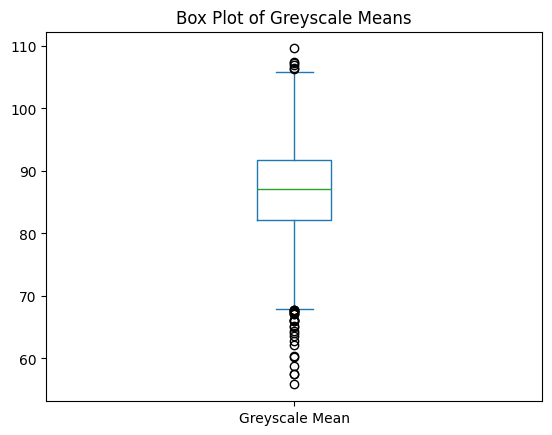

In [16]:
# Box and whisker plots - adjusted for single feature
dataset.plot(kind='box', y='Greyscale Mean', title='Box Plot of Greyscale Means')
plt.show()

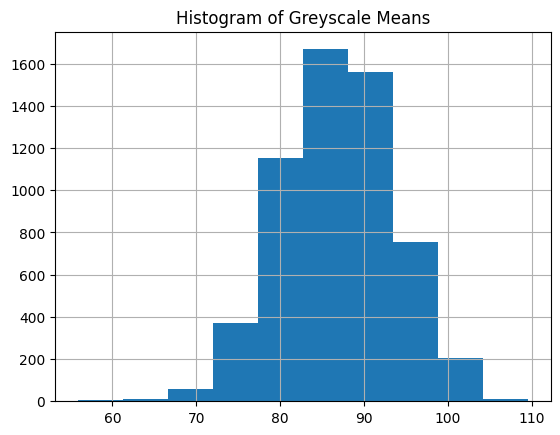

In [17]:
# Histograms - adjusted for single feature
dataset['Greyscale Mean'].hist()
plt.title('Histogram of Greyscale Means')
plt.show()

In [18]:
# Split-out validation dataset THIS IS AN IMPORTANT STEP
array = dataset.values
X = array[:,0:1]  # Adjusted to select only the greyscale column
y = array[:,1]
X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.35, random_state=1) #THE .35 REFERS TO THE PERCENTAGE OF THE FILES WHICH WILL BE VALIDATED

In [19]:
# Spot Check Algorithms In this section, we compare multiple 
# machine learning algorithms to identify the best-performing 
# model for our dataset. The models include Logistic Regression, 
# Linear Discriminant Analysis, K-Nearest Neighbors, Decision Trees, 
# Naive Bayes, and Support Vector Machines.
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))  # BEST FIT MODEL FOR BINARY DISTRIBUTION
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))  # BUILDS USING ON VALUES TO FIND THE N VALUE BETWEEN CLUSTERS
models.append(('CART', DecisionTreeClassifier())) # BEST DECISION IN DECISON TREE SELECTS THE BEST
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))

/Users/syedahmed/Desktop/BSCs/L5/sem B/DataScience project/ChestXRayApp/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/syedahmed/Desktop/BSCs/L5/sem B/DataScience project/ChestXRayApp/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/syedahmed/Desktop/BSCs/L5/sem B/DataScience project/ChestXRayApp/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..))

LR: 0.737663 (0.007048)
LDA: 0.756495 (0.010243)
KNN: 0.748804 (0.013936)
CART: 0.691511 (0.005601)
NB: 0.756761 (0.008217)
SVM: 0.769762 (0.000929)


/var/folders/9g/w9cw5s7d3nj7d1blhyzzljfm0000gn/T/ipykernel_55830/1367300985.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(results, labels=names)


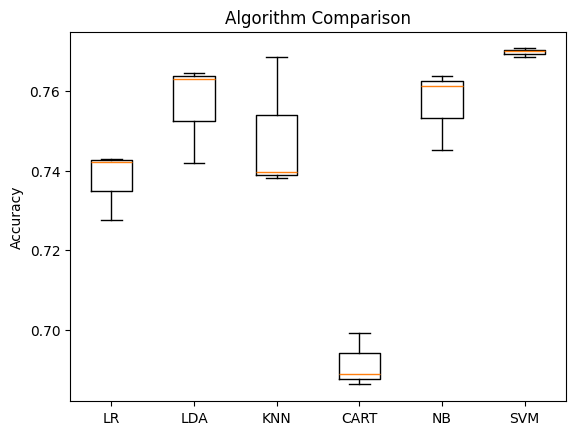

In [20]:
# evaluate each model in turn
results = []
names = []
for name, model in models:
	kfold = StratifiedKFold(n_splits=3, random_state=1, shuffle=True)
	cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
	results.append(cv_results)
	names.append(name)
	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.ylabel('Accuracy')
plt.show()

In [21]:
# Hyper-parameter Optimisation for SVM

param_dist = {
    'C': uniform(0.01, 100),
    'gamma': uniform(0.0001, 1),
    'kernel': ['rbf']
}

# Randomised Search
random_search = RandomizedSearchCV(
    estimator=SVC(),
    param_distributions=param_dist,
    n_iter=20,
    scoring='accuracy',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, Y_train)

print("Best Parameters:", random_search.best_params_)
print("Best Accuracy:", random_search.best_score_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END C=15.611864044243651, gamma=0.15609452033620264, kernel=rbf; total time=   0.6s
[CV] END C=15.611864044243651, gamma=0.15609452033620264, kernel=rbf; total time=   0.8s
[CV] END C=37.464011884736244, gamma=0.9508143064099162, kernel=rbf; total time=   1.2s
[CV] END C=5.818361216819946, gamma=0.8662761457749352, kernel=rbf; total time=   0.5s
[CV] END C=73.20939418114051, gamma=0.5987584841970366, kernel=rbf; total time=   1.3s
[CV] END C=37.464011884736244, gamma=0.9508143064099162, kernel=rbf; total time=   1.4s
[CV] END C=5.818361216819946, gamma=0.8662761457749352, kernel=rbf; total time=   0.5s
[CV] END C=37.464011884736244, gamma=0.9508143064099162, kernel=rbf; total time=   1.8s
[CV] END C=15.611864044243651, gamma=0.15609452033620264, kernel=rbf; total time=   1.2s
[CV] END C=5.818361216819946, gamma=0.8662761457749352, kernel=rbf; total time=   0.7s
[CV] END C=2.0684494295802445, gamma=0.9700098521619943, ker

In [22]:
# Use the best model for predictions
best_model = random_search.best_estimator_
predictions = best_model.predict(X_validation)
print("Best Model:", random_search.best_estimator_)

Best Model: SVC(C=np.float64(59.251456886204245), gamma=np.float64(0.04655041271999773))


In [23]:
model = best_model
model.fit(X_train, Y_train)
predictions = model.predict(X_validation)

0.7783251231527094
[[ 269  263]
 [ 187 1311]]
              precision    recall  f1-score   support

      Normal       0.59      0.51      0.54       532
   Pneumonia       0.83      0.88      0.85      1498

    accuracy                           0.78      2030
   macro avg       0.71      0.69      0.70      2030
weighted avg       0.77      0.78      0.77      2030



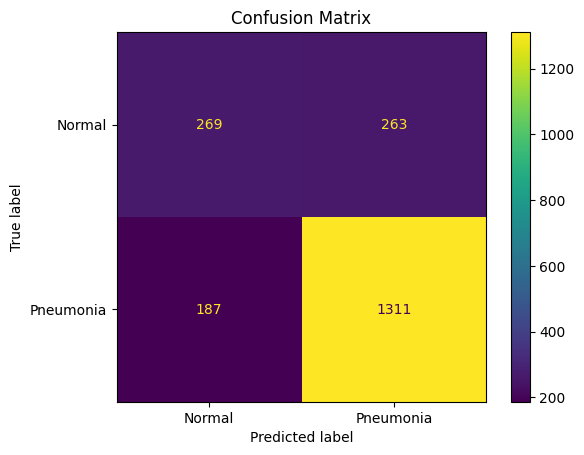

In [24]:
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

# Plot Confusion Matrix: The confusion matrix provides insights into the model's
# performance by showing the number of true positives, false positives, true negatives,
# and false negatives. This helped us understand where the model is making errors.
ConfusionMatrixDisplay.from_predictions(Y_validation, predictions, display_labels=['Normal', 'Pneumonia'])
plt.title("Confusion Matrix")
plt.show()

In [25]:
directory = ['./images/TEST SET/test summary means.csv']

# Load each CSV file and concatenate into one DataFrame [6]
unseen_data_frames = [pandas.read_csv(f) for f in directory]
data = pandas.concat(unseen_data_frames, ignore_index=True)

# Select test criteria [7][8]
features_for_prediction = data.iloc[:, [0]].values

# Select the trained model [9]
predictions = model.predict(features_for_prediction)

# Print predictions for each unseen image
for i, prediction in enumerate(predictions):
    print(f"Unseen image {i} predicted as: {prediction}")

Unseen image 0 predicted as: Normal
Unseen image 1 predicted as: Normal
Unseen image 2 predicted as: Pneumonia
Unseen image 3 predicted as: Normal
Unseen image 4 predicted as: Pneumonia
Unseen image 5 predicted as: Normal
Unseen image 6 predicted as: Pneumonia
Unseen image 7 predicted as: Pneumonia
Unseen image 8 predicted as: Normal
Unseen image 9 predicted as: Pneumonia
Unseen image 10 predicted as: Pneumonia
Unseen image 11 predicted as: Pneumonia
Unseen image 12 predicted as: Pneumonia
Unseen image 13 predicted as: Normal
Unseen image 14 predicted as: Normal
Unseen image 15 predicted as: Normal
Unseen image 16 predicted as: Normal
Unseen image 17 predicted as: Normal
Unseen image 18 predicted as: Pneumonia
Unseen image 19 predicted as: Pneumonia
Unseen image 20 predicted as: Pneumonia
Unseen image 21 predicted as: Pneumonia
Unseen image 22 predicted as: Pneumonia
Unseen image 23 predicted as: Pneumonia
Unseen image 24 predicted as: Pneumonia
Unseen image 25 predicted as: Pneumonia


In [26]:
# Confirm the full path
output_path = os.path.abspath('../backend/model/model.pkl')  # Adjust path as needed
print(f"Saving model to: {output_path}")

# Save the trained model
with open(output_path, 'wb') as f:
    pickle.dump(model, f)

print("✅ Model saved successfully from Jupyter!")

Saving model to: /Users/syedahmed/Desktop/BSCs/L5/sem B/DataScience project/ChestXRayApp/backend/model/model.pkl
✅ Model saved successfully from Jupyter!
